In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

## Data

Data was collected by having a subject complete the in-class word recognition task. They were given 90 seconds to memorize the words, 2 minutes of a reset in between, then 1 minute to type the words they thought belonged to the old set.

In [ ]:
# total items
old_items = ["Drum", "Curtain", "Bell", "Coffee", "School", "Parent", "Moon","Garden", "Hat", "Farmer", "Nose", "Turkey", "Color", "House", "River", "Desk", "Ranger", "Mountain", "Glasses", "Towel"]
new_items = ["Dog", "Music", "Towel","Parent", "Chin", "Window", "Garden", "Home", "Mountain", "Nose", "Tool", "Horse", "Road", "Curtain", "School", "Letter", "River", "Dish", "Bell", "Color"]

# experimental results
correct_old_items = ["Towel", "Mountain", "Nose", "Curtain", "School", "Bell", "Color", "Parent", "Garden", "River"]
incorrect_old_items = ["Window"]
correct_new_items = ["Dog", "Music", "Chin", "Home", "Tool", "Horse", "Road", "Letter", "Dish"]
incorrect_new_items = []
total_items = len(correct_old_items) + len(incorrect_old_items) + len(correct_new_items) + len(incorrect_new_items)

# categories
categories = ["Correct Old Items", "Incorrect Old Items", "Correct New Items", "Incorrect New Items"]

# store frequencies as data
data = [len(correct_old_items), len(incorrect_old_items), len(correct_new_items), len(incorrect_new_items)]
percent_new = (len(correct_new_items) + len(incorrect_new_items)) / (total_items)

## One-high-threshold Multinomial Processing Tree (MPT) Model.

### Parameters and Model

The table below lists the four latent parameters and corresponding interpretations:


| Parameter | Description | 
| --- | --- |
| $d$ | Probability of remembering a word |
| $g$ | Probability of guessing a word was an old item |


The table below lists the four types of responses (categories):


| Response (Category) | Description |
| --- | --- |
| Old Item Correct | The subject correctly identified an original word as belonging to the original set. |
| Old Item Incorrect | The subject incorrectly identified an original word as NOT belonging to the original set. |
| New Item Correct | The subject correctly identified a new word as NOT belonging to the original set. |
| New Item Incorrect | The subject incorrectly identified a new word as belonging to the original set |


The graph below shows the model:
```
+-----------------------------------+
|                                   |
|             d ----------- "old"   |
|            /                      |
| Old Items <       g ----- "old"   |
|            \     /                |
|             1-d <                 |
|                  \                |
|                   1-g --- "new"   |
|                                   |
|             g ----------- "old"   |
|            /                      |
| New Items <                       |
|            \                      |
|             1-g --------- "new"   |
|                                   |
+-----------------------------------+

```

### Simulating the Model

In [66]:
mpt_model_1ht_code = """
data {
  int<lower=1> N; // Number of trials
  int<lower=1> K; // Number of categories
  array[K] int<lower=0, upper=N> freqs;
  real<lower=0, upper=1> percent_new;
}

parameters {
  real<lower=0, upper=1> d;
  real<lower=0, upper=1> g;
}

transformed parameters {
  simplex[K] theta;

  // Your code here - need to fill in the entries of the simplex according to the tree
  theta[1] = (d + ((1-d) * g)) * (1-percent_new); //old item correct
  theta[2] = ((1-d) * (1-g)) * (1-percent_new);   //old item incorrect
  theta[3] = ((1-g)) * (percent_new);             //new item correct
  theta[4] = (g) * (percent_new);                 //new item incorrect
}

model {
  // Assuming uniform priors
  target += beta_lpdf(d | 1, 1);
  target += beta_lpdf(g | 1, 1);

  // Multinomial likelihood
  target += multinomial_lpmf(freqs | theta);
}
"""

In [67]:
### Compile, fit, and diagnose model
# Prepare data
stan_dict = {
    'freqs': data,
    'N': total_items,
    'K': len(categories),
    'percent_new': percent_new
}

# Compile model
posterior = stan.build(mpt_model_1ht_code, data=stan_dict, random_seed=42)


# Sample (i.e., inverse inference)
fit = posterior.sample(num_chains=4, num_samples=2500, num_warmup=1000)

Building...



Building: 24.7s, done.Sampling:   0%
Sampling:  25% (3500/14000)
Sampling:  50% (7000/14000)
Sampling:  75% (10500/14000)
Sampling: 100% (14000/14000)
Sampling: 100% (14000/14000), done.
Messages received during sampling:
  Gradient evaluation took 1.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.16 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.19 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.
  Adjust your expectations accordingly!


In [68]:
### Parameter recovery and predictions
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d,0.827,0.109,0.630,0.992,0.001,0.001,5054.0,4115.0,1.0
g,0.099,0.090,0.000,0.268,0.001,0.001,4623.0,3088.0,1.0
theta[0],0.465,0.052,0.370,0.546,0.001,0.001,5335.0,4297.0,1.0
theta[1],0.085,0.052,0.004,0.180,0.001,0.001,5335.0,4297.0,1.0
theta[2],0.405,0.041,0.329,0.450,0.001,0.000,4623.0,3088.0,1.0
theta[3],0.045,0.041,0.000,0.121,0.001,0.000,4623.0,3088.0,1.0


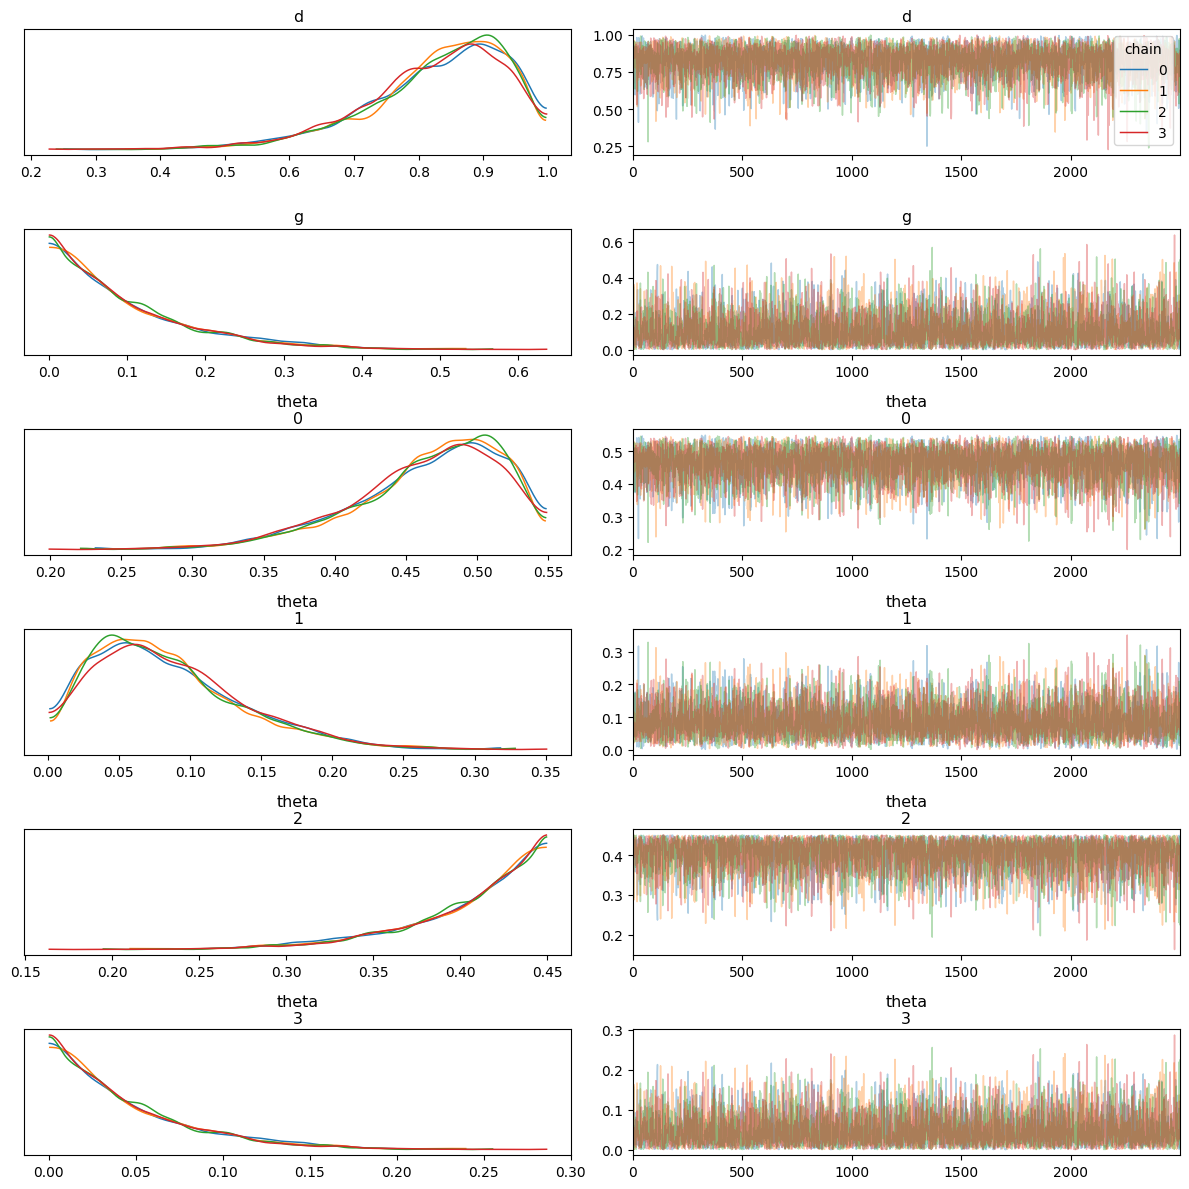

In [69]:
# Traceplots and marginals - visual convergence checks
axarr = az.plot_trace(fit, compact=False, legend=True)
plt.tight_layout()

### One-high-threshold Analysis

All parameters converge. d is estimated to be around 0.83 with a standard deviation of 0.11 and g is estimated to be around 0.10 with a standard deviation of 0.09. This model attributes all new word classification to the guess parameter, so g here essentially shows the success rate of recognizing a new word.

## Two-high-threshold Multinomial Processing Tree (MPT) Model

### Parameters and Model

The table below lists the four latent parameters and corresponding interpretations:


| Parameter | Description | 
| --- | --- |
| $d$ | Probability of remembering a word |
| $g$ | Probability of guessing a word is an old item |


The table below lists the four types of responses (categories):


| Response (Category) | Description |
| --- | --- |
| Old Item Correct | The subject correctly identified an original word as belonging to the original set. |
| Old Item Incorrect | The subject incorrectly identified an original word as NOT belonging to the original set. |
| New Item Correct | The subject correctly identified a new word as NOT belonging to the original set. |
| New Item Incorrect | The subject incorrectly identified a new word as belonging to the original set |


The graph below shows the model:
```
+-----------------------------------+
|                                   |
|             d ----------- "old"   |
|            /                      |
| Old Items <       g ----- "old"   |
|            \     /                |
|             1-d <                 |
|                  \                |
|                   1-g --- "new"   |
|                                   |
|             d ----------- "new"   |
|            /                      |
| New Items <       g ----- "old"   |
|            \     /                |
|             1-d <                 |
|                  \                |
|                   1-g --- "new"   |
+-----------------------------------+

```

### Simulating the Model

In [70]:
mpt_model_2ht_code = """
data {
  int<lower=1> N; // Number of trials
  int<lower=1> K; // Number of categories
  array[K] int<lower=0, upper=N> freqs;
  real<lower=0, upper=1> percent_new;
}

parameters {
  real<lower=0, upper=1> d;
  real<lower=0, upper=1> g;
}

transformed parameters {
  simplex[K] theta;

  // Your code here - need to fill in the entries of the simplex according to the tree
  theta[1] = (d + ((1-d) * g))  * (1-percent_new);    //old item correct
  theta[2] = ((1-d) * (1-g))  * (1-percent_new);      //old item incorrect
  theta[3] = (d + ((1-d) * (1-g)))  * (percent_new);  // new item correct
  theta[4] = (((1-d) * g))  * (percent_new);          // new item incorrect
}

model {
  // Assuming uniform priors
  target += beta_lpdf(d | 1, 1);
  target += beta_lpdf(g | 1, 1);

  // Multinomial likelihood
  target += multinomial_lpmf(freqs | theta);
}
"""

In [71]:
### Compile, fit, and diagnose model
# Prepare data
stan_dict = {
    'freqs': data,
    'N': total_items,
    'K': len(categories),
    'percent_new': percent_new
}

# Compile model
posterior = stan.build(mpt_model_2ht_code, data=stan_dict, random_seed=42)


# Sample (i.e., inverse inference)
fit = posterior.sample(num_chains=4, num_samples=2500, num_warmup=1000)

Building...



Building: 24.8s, done.Sampling:   0%
Sampling:  25% (3500/14000)
Sampling:  50% (7000/14000)
Sampling:  75% (10500/14000)
Sampling: 100% (14000/14000)
Sampling: 100% (14000/14000), done.
Messages received during sampling:
  Gradient evaluation took 5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.5 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.3 seconds.
  Adjust your expectations accordingly!


In [72]:
### Parameter recovery and predictions
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d,0.830,0.110,0.632,0.995,0.001,0.001,6469.0,4800.0,1.0
g,0.345,0.236,0.000,0.762,0.003,0.002,6041.0,4015.0,1.0
theta[0],0.489,0.045,0.406,0.549,0.001,0.001,6976.0,5579.0,1.0
theta[1],0.061,0.045,0.001,0.144,0.001,0.001,6976.0,5579.0,1.0
theta[2],0.423,0.028,0.370,0.450,0.000,0.000,4980.0,4394.0,1.0
theta[3],0.027,0.028,0.000,0.080,0.000,0.000,4980.0,4394.0,1.0


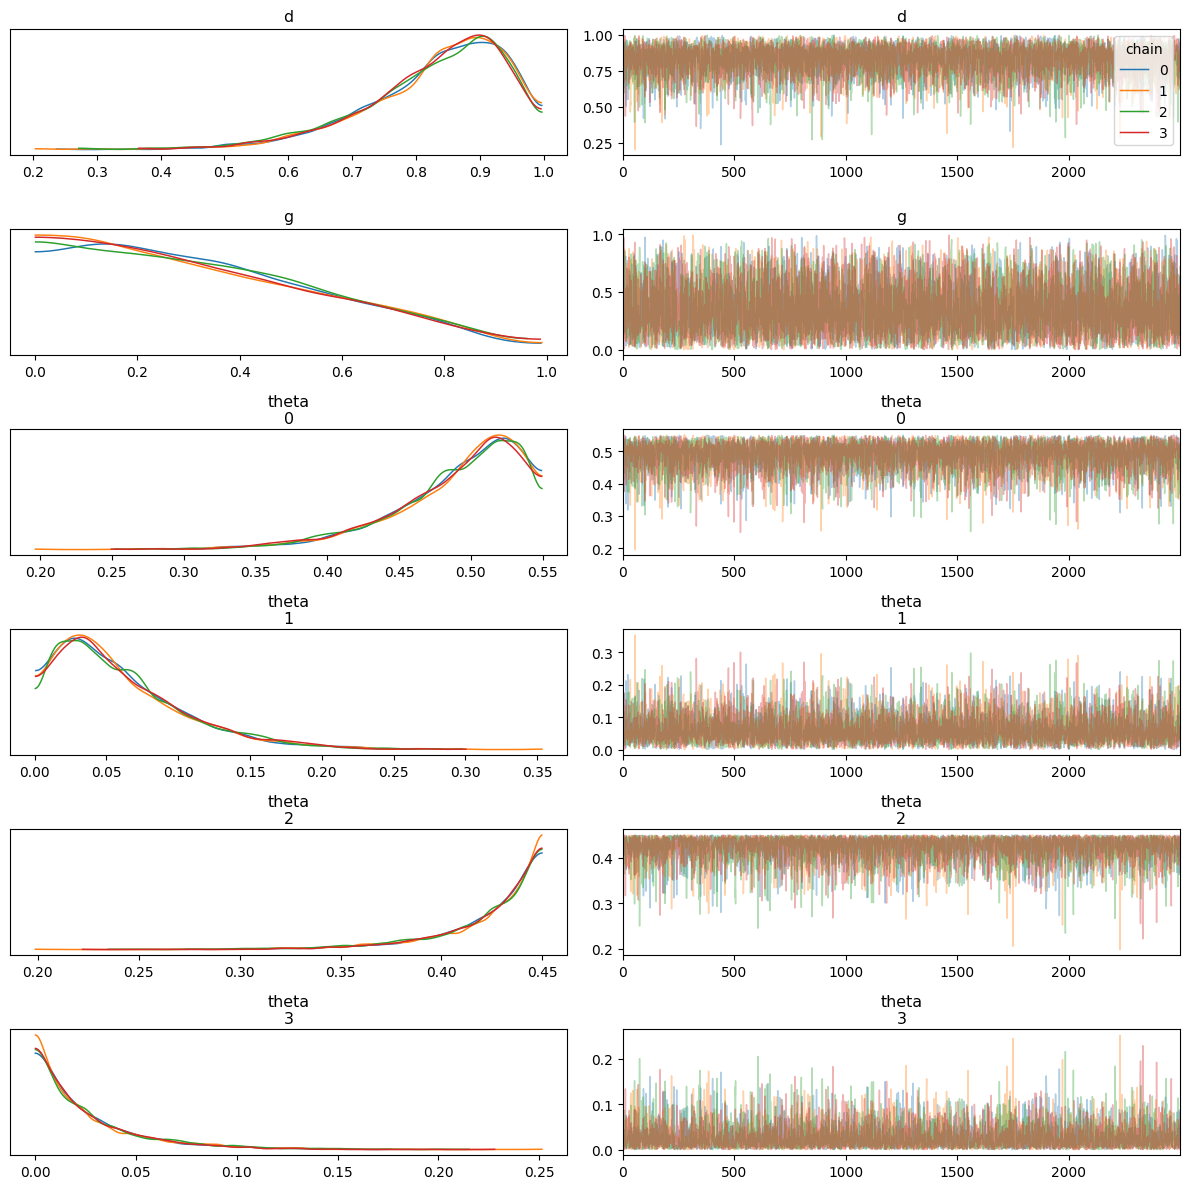

In [73]:
# Traceplots and marginals - visual convergence checks
axarr = az.plot_trace(fit, compact=False, legend=True)
plt.tight_layout()

### Two-high-threshold Analysis

All parameters converge. d is estimated to be around 0.83 with a standard deviation of 0.11 and g is estimated to be around 0.35 with a standard deviation of 0.24. This model attributes some determination ability to the successful recognition of new items, and so the guess rate is higher as this model doesn't lock it to the rate of correct new item identification, allowing it to attribute more success to guesses rather than pure determination.

## MPT Model Comparison

The models predict very similar values of d, attributing the same probability to the subject remembering properly if the item is new or old. The one-high-threshold attributes a very low guess probability where the two-high-threshold attributes a guess rate 2.5 times higher (0.35 vs 0.10). This is directly due to the introduction of allowing d to be responsible for part of the correct new item classifications.

Comparing the theta values, we can see that the curves are tighter (i.e. lower standard deviation) for the two-high-threshold, meaning the additional threshold allowed the model to be more consistent with it's determination of these values. However, g has a higher standard deviation for the two-high-threshold, likely due to the fact that d and g are both influenced by new and old item classifications.

The effective sample size and r_hat values look good for both models.